# Data Modelling Lab Project 
**Topic:** - Neural Machine Translation

**Name:** - Srinithi S L

**SC Code:** - SC25M168

**Course:** - Data Modelling Lab 

**Code Implementation in this file** - Data Visualization

## Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import torch
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')
import os

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SRI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\SRI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
df=pd.read_csv('eng_-french.csv')

In [3]:
df.head(10)

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !
5,Fire!,Au feu !
6,Help!,À l'aide !
7,Jump.,Saute.
8,Stop!,Ça suffit !
9,Stop!,Stop !


In [4]:
try:
    from wordcloud import WordCloud
    wordcloud_available = True
except:
    wordcloud_available = False
    print("WordCloud not available.")


In [8]:
class NeuralTranslationPreprocessor:
    def __init__(self):
        self.viz_folder = 'data_visualization'
        if not os.path.exists(self.viz_folder):
            os.makedirs(self.viz_folder)
            print(f"Created folder: {self.viz_folder}")
    
    def load_data(self, data_path=None, df=None):
        if df is not None:
            self.df = df.copy()
        else:
            self.df = pd.read_csv(data_path)
        if 'English words/sentences' in self.df.columns:
            self.df = self.df.rename(columns={'English words/sentences': 'english','French words/sentences': 'french'})
        print(f"Dataset loaded with {len(self.df)} number of datapoints")
        return self.df
    
    def basic_cleaning(self, text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()
        return text
    
    def advanced_cleaning(self, text, language='en'):
        if pd.isna(text):
            return ""
        text = str(text)
        text = re.sub(r'[""''`]', '"', text)  
        text = re.sub(r'[–—]', '-', text)     
        #Handle contractions
        if language == 'en':
            contractions = {
                "won't": "will not", "can't": "cannot", "n't": " not","'re": " are", "'ve": " have", "'ll": " will",
                "'d": " would", "'m": " am"}
            for contraction, expansion in contractions.items():
                text = text.replace(contraction, expansion) 
        #Remove URLs and emails
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def tokenize_simple(self, text):
        if pd.isna(text) or text == "":
            return []
        tokens = word_tokenize(text.lower())
        tokens = [token for token in tokens if token.isalpha()]
        return tokens
    
    def tokenize_spacy(self, text, language='en'):
        if pd.isna(text) or text == "":
            return []
        nlp = nlp_en if language == 'en' else nlp_fr
        doc = nlp(text)
        tokens = []
        for token in doc:
            if not token.is_stop and not token.is_punct and not token.is_space:
                tokens.append(token.lemma_.lower())
        return tokens
    
    def preprocess_dataset(self):
        print("Starting the data preprocessing step")
        self.df['english_clean'] = self.df['english'].apply(self.basic_cleaning)
        self.df['french_clean'] = self.df['french'].apply(self.basic_cleaning)
        self.df['english_advanced'] = self.df['english_clean'].apply(lambda x: self.advanced_cleaning(x, 'en'))
        self.df['french_advanced'] = self.df['french_clean'].apply(lambda x: self.advanced_cleaning(x, 'fr'))
        self.df['english_tokens'] = self.df['english_advanced'].apply(self.tokenize_simple)
        self.df['french_tokens'] = self.df['french_advanced'].apply(self.tokenize_simple)
        #Calculate sequence lengths
        self.df['english_length'] = self.df['english_tokens'].apply(len)
        self.df['french_length'] = self.df['french_tokens'].apply(len)
        #Create processed text
        self.df['english_processed'] = self.df['english_tokens'].apply(lambda x: ' '.join(x))
        self.df['french_processed'] = self.df['french_tokens'].apply(lambda x: '<START> ' + ' '.join(x) + ' <END>')
        #Remove empty sequences
        initial_size = len(self.df)
        self.df = self.df[(self.df['english_length'] > 0) & (self.df['french_length'] > 0)]
        print(f"Removed {initial_size - len(self.df)} empty sequences")
        return self.df
    
    def get_vocabulary_stats(self):
        english_tokens = [token for tokens in self.df['english_tokens'] for token in tokens]
        french_tokens = [token for tokens in self.df['french_tokens'] for token in tokens]
        english_vocab = set(english_tokens)
        french_vocab = set(french_tokens)
        stats = {
            'english_vocab_size': len(english_vocab),
            'french_vocab_size': len(french_vocab),
            'english_total_tokens': len(english_tokens),
            'french_total_tokens': len(french_tokens),
            'english_unique_ratio': len(english_vocab) / len(english_tokens) if english_tokens else 0,
            'french_unique_ratio': len(french_vocab) / len(french_tokens) if french_tokens else 0
        }
        return stats, english_vocab, french_vocab
    
    def plot_sequence_length_distribution(self):
        plt.figure(figsize=(10, 6))
        plt.hist(self.df['english_length'], bins=30, alpha=0.7, label='English', color='blue')
        plt.hist(self.df['french_length'], bins=30, alpha=0.7, label='French', color='red')
        plt.xlabel('Sequence Length', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title('Sequence Length Distribution', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{self.viz_folder}/01_sequence_length_distribution.png', dpi=300, bbox_inches='tight')
        print("Saved: 01_sequence_length_distribution.png")
        plt.show()
        plt.close()
    
    def plot_boxplot(self):
        plt.figure(figsize=(8, 6))
        data_lengths = [self.df['english_length'], self.df['french_length']]
        plt.boxplot(data_lengths, labels=['English', 'French'])
        plt.title('Sequence Length Box Plot', fontsize=14, fontweight='bold')
        plt.ylabel('Length', fontsize=12)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{self.viz_folder}/02_boxplot_sequence_lengths.png', dpi=300, bbox_inches='tight')
        print("Saved: 02_boxplot_sequence_lengths.png")
        plt.show()
        plt.close()
    
    def plot_length_correlation(self):
        plt.figure(figsize=(8, 6))
        plt.scatter(self.df['english_length'], self.df['french_length'], alpha=0.5, s=20)
        plt.xlabel('English Length', fontsize=12)
        plt.ylabel('French Length', fontsize=12)
        plt.title('Length Correlation', fontsize=14, fontweight='bold')
        correlation = self.df['english_length'].corr(self.df['french_length'])
        plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, fontsize=11,bbox=dict(boxstyle='round', 
                                                                                                                     facecolor='wheat', alpha=0.5))
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{self.viz_folder}/03_length_correlation.png', dpi=300, bbox_inches='tight')
        print("Saved: 03_length_correlation.png")
        plt.show()
        plt.close()
    
    def plot_top_words_english(self):
        english_tokens = [token for tokens in self.df['english_tokens'] for token in tokens]
        english_freq = Counter(english_tokens).most_common(15)
        plt.figure(figsize=(10, 6))
        words, counts = zip(*english_freq)
        plt.barh(range(len(words)), counts, color='steelblue')
        plt.yticks(range(len(words)), words, fontsize=10)
        plt.xlabel('Frequency', fontsize=12)
        plt.title('Top 15 English Words', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{self.viz_folder}/04_top_english_words.png', dpi=300, bbox_inches='tight')
        print("Saved: 04_top_english_words.png")
        plt.show()
        plt.close()
    
    def plot_top_words_french(self):
        french_tokens = [token for tokens in self.df['french_tokens'] for token in tokens]
        french_freq = Counter(french_tokens).most_common(15)
        plt.figure(figsize=(10, 6))
        words, counts = zip(*french_freq)
        plt.barh(range(len(words)), counts, color='coral')
        plt.yticks(range(len(words)), words, fontsize=10)
        plt.xlabel('Frequency', fontsize=12)
        plt.title('Top 15 French Words', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{self.viz_folder}/05_top_french_words.png', dpi=300, bbox_inches='tight')
        print("Saved: 05_top_french_words.png")
        plt.show()
        plt.close()
    
    def plot_vocabulary_growth(self):
        plt.figure(figsize=(10, 6))
        english_vocab_growth = []
        french_vocab_growth = []
        en_vocab = set()
        fr_vocab = set()
        
        for en_tokens, fr_tokens in zip(self.df['english_tokens'], self.df['french_tokens']):
            en_vocab.update(en_tokens)
            fr_vocab.update(fr_tokens)
            english_vocab_growth.append(len(en_vocab))
            french_vocab_growth.append(len(fr_vocab))
        
        plt.plot(english_vocab_growth, label='English', color='blue', linewidth=2)
        plt.plot(french_vocab_growth, label='French', color='red', linewidth=2)
        plt.xlabel('Number of Sentences', fontsize=12)
        plt.ylabel('Vocabulary Size', fontsize=12)
        plt.title('Vocabulary Growth', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{self.viz_folder}/06_vocabulary_growth.png', dpi=300, bbox_inches='tight')
        print("Saved: 06_vocabulary_growth.png")
        plt.show()
        plt.close()
    
    def plot_length_ratio(self):
        plt.figure(figsize=(10, 6))
        length_ratios = self.df['french_length'] / (self.df['english_length'] + 1e-8)
        plt.hist(length_ratios, bins=30, alpha=0.7, color='purple', edgecolor='black')
        plt.xlabel('French/English Length Ratio', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title('Length Ratio Distribution', fontsize=14, fontweight='bold')
        plt.axvline(x=length_ratios.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {length_ratios.mean():.2f}')
        plt.legend(fontsize=11)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{self.viz_folder}/07_length_ratio_distribution.png', dpi=300, bbox_inches='tight')
        print("Saved: 07_length_ratio_distribution.png")
        plt.show()
        plt.close()
    
    def plot_statistics_summary(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.axis('off')
        stats, _, _ = self.get_vocabulary_stats()
        stats_text = f"""
Dataset Statistics Summary: 

Total Samples: {len(self.df):,}

English Statistics:
    • Vocabulary Size: {stats['english_vocab_size']:,}
    • Total Tokens: {stats['english_total_tokens']:,}
    • Average Length: {self.df['english_length'].mean():.2f} tokens
    • Min Length: {self.df['english_length'].min()} tokens
    • Max Length: {self.df['english_length'].max()} tokens

French Statistics:
    • Vocabulary Size: {stats['french_vocab_size']:,}
    • Total Tokens: {stats['french_total_tokens']:,}
    • Average Length: {self.df['french_length'].mean():.2f} tokens
    • Min Length: {self.df['french_length'].min()} tokens
    • Max Length: {self.df['french_length'].max()} tokens

Length Correlation: {self.df['english_length'].corr(self.df['french_length']):.3f}

95th Percentile Length: {int(np.percentile(self.df[['english_length', 'french_length']].max(axis=1), 95))} tokens
        """
        
        ax.text(0.5, 0.5, stats_text, fontsize=11, verticalalignment='center',
               horizontalalignment='center', family='monospace',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
        
        plt.tight_layout()
        plt.savefig(f'{self.viz_folder}/08_statistics_summary.png', dpi=300, bbox_inches='tight')
        print("Saved: 08_statistics_summary.png")
        plt.show()
        plt.close()
    
    def plot_wordcloud_english(self):
        if not wordcloud_available:
            print("Skipped: English word cloud (WordCloud not available)")
            return
        english_tokens = [token for tokens in self.df['english_tokens'] for token in tokens]
        english_text = ' '.join(english_tokens[:10000])
        plt.figure(figsize=(12, 6))
        wordcloud_en = WordCloud(width=800, height=400, background_color='white',colormap='Blues').generate(english_text)
        plt.imshow(wordcloud_en, interpolation='bilinear')
        plt.title('English Word Cloud', fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'{self.viz_folder}/09_english_wordcloud.png', dpi=300, bbox_inches='tight')
        print("Saved: 09_english_wordcloud.png")
        plt.show()
        plt.close()
    
    def plot_wordcloud_french(self):
        if not wordcloud_available:
            print("Skipped: French word cloud (WordCloud not available)")
            return
        french_tokens = [token for tokens in self.df['french_tokens'] for token in tokens]
        french_text = ' '.join(french_tokens[:10000])
        
        plt.figure(figsize=(12, 6))
        wordcloud_fr = WordCloud(width=800, height=400, background_color='white',colormap='Reds').generate(french_text)
        plt.imshow(wordcloud_fr, interpolation='bilinear')
        plt.title('French Word Cloud', fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'{self.viz_folder}/10_french_wordcloud.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print("Saved: 10_french_wordcloud.png")
    
    def plot_character_length_distribution(self):
        plt.figure(figsize=(10, 6))
        english_char_lengths = self.df['english'].str.len()
        french_char_lengths = self.df['french'].str.len() 
        plt.hist(english_char_lengths, bins=30, alpha=0.7, label='English', color='blue')
        plt.hist(french_char_lengths, bins=30, alpha=0.7, label='French', color='red')
        plt.xlabel('Character Length', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title('Character Length Distribution', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{self.viz_folder}/11_character_length_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print("Saved: 11_character_length_distribution.png")
    
    def plot_translation_complexity(self):
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(self.df['english_length'], self.df['french_length'], c=self.df.index, alpha=0.6, cmap='viridis', s=20)
        plt.xlabel('English Tokens', fontsize=12)
        plt.ylabel('French Tokens', fontsize=12)
        plt.title('Translation Complexity', fontsize=14, fontweight='bold')
        plt.colorbar(scatter, label='Sample Index')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{self.viz_folder}/12_translation_complexity.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print("Saved: 12_translation_complexity.png")
    
    def create_all_visualizations(self):
        print(f"\nGenerating visualizations in '{self.viz_folder}' folder...")        
        self.plot_sequence_length_distribution()
        self.plot_boxplot()
        self.plot_length_correlation()
        self.plot_top_words_english()
        self.plot_top_words_french()
        self.plot_vocabulary_growth()
        self.plot_length_ratio()
        self.plot_statistics_summary()
        self.plot_wordcloud_english()
        self.plot_wordcloud_french()
        self.plot_character_length_distribution()
        self.plot_translation_complexity() 
    
    def prepare_for_transformer(self, max_length=None):
        if max_length is None:
            max_length = int(np.percentile(
                self.df[['english_length', 'french_length']].max(axis=1), 95))
        
        print(f"Using max_length: {max_length}")
        mask = (self.df['english_length'] <= max_length) & (self.df['french_length'] <= max_length)
        filtered_df = self.df[mask].copy()
        print(f"Filtered dataset: {len(filtered_df)} samples (removed {len(self.df) - len(filtered_df)} long sequences)")
        filtered_df['source'] = filtered_df['english_processed']
        filtered_df['target'] = filtered_df['french_processed']
        return filtered_df[['source', 'target', 'english_length', 'french_length']]
    
    def get_preprocessing_summary(self):
        stats, _, _ = self.get_vocabulary_stats()
        
        summary = f"""
Preprocessing Summary:

Dataset Information:
- Total samples: {len(self.df):,}
- Average English length: {self.df['english_length'].mean():.2f} tokens
- Average French length: {self.df['french_length'].mean():.2f} tokens
- Length correlation: {self.df['english_length'].corr(self.df['french_length']):.3f}

Vocabulary Statistics:
- English vocabulary size: {stats['english_vocab_size']:,}
- French vocabulary size: {stats['french_vocab_size']:,}
- English tokens/vocab ratio: {stats['english_unique_ratio']:.3f}
- French tokens/vocab ratio: {stats['french_unique_ratio']:.3f}

Sequence Length Statistics:
- Min English length: {self.df['english_length'].min()}
- Max English length: {self.df['english_length'].max()}
- Min French length: {self.df['french_length'].min()}
- Max French length: {self.df['french_length'].max()}
- 95th percentile length: {int(np.percentile(self.df[['english_length', 'french_length']].max(axis=1), 95))}
        """
        
        return summary

In [9]:
def main():
    #Initialize preprocessor
    preprocessor = NeuralTranslationPreprocessor()
    #Load data
    df = pd.read_csv('eng_-french.csv')
    #Load and preprocess data
    preprocessor.load_data(df=df)
    processed_df = preprocessor.preprocess_dataset() 
    #Print preprocessing summary
    print(preprocessor.get_preprocessing_summary())
    #Visualizations
    preprocessor.create_all_visualizations()
    # Prepare data for transformer
    transformer_ready_data = preprocessor.prepare_for_transformer(max_length=50)
    print("\nTransformer-ready data shape:", transformer_ready_data.shape)
    print("\nFirst few samples:")
    print(transformer_ready_data.head())
    return preprocessor, transformer_ready_data

Dataset loaded with 175621 number of datapoints
Starting the data preprocessing step
Removed 685 empty sequences

Preprocessing Summary:

Dataset Information:
- Total samples: 174,936
- Average English length: 6.44 tokens
- Average French length: 5.94 tokens
- Length correlation: 0.776

Vocabulary Statistics:
- English vocabulary size: 13,786
- French vocabulary size: 22,538
- English tokens/vocab ratio: 0.012
- French tokens/vocab ratio: 0.022

Sequence Length Statistics:
- Min English length: 1
- Max English length: 47
- Min French length: 1
- Max French length: 51
- 95th percentile length: 12
        

Generating visualizations in 'data_visualization' folder...
Saved: 01_sequence_length_distribution.png


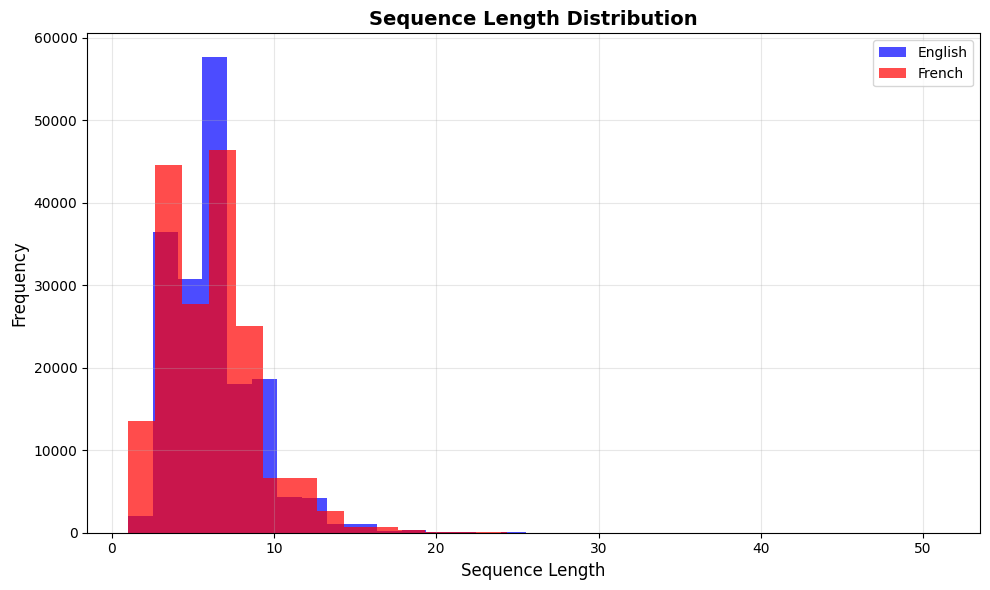

Saved: 02_boxplot_sequence_lengths.png


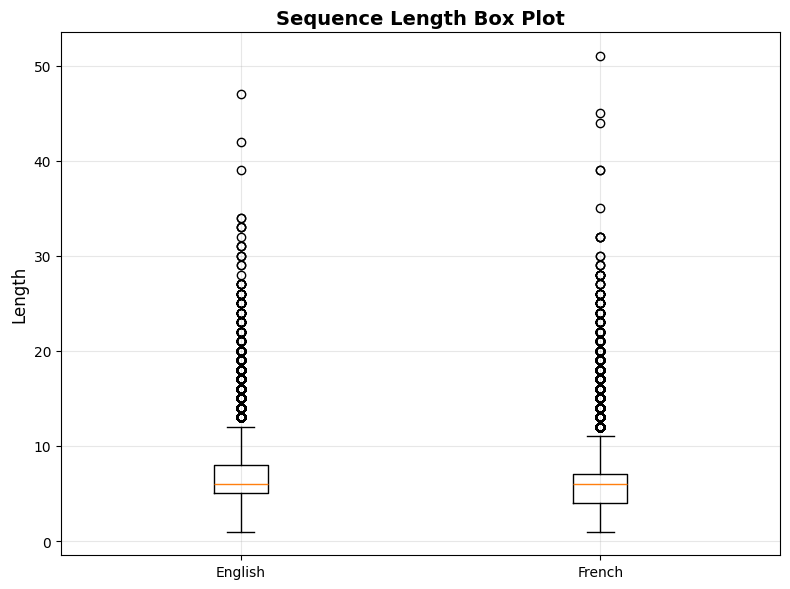

Saved: 03_length_correlation.png


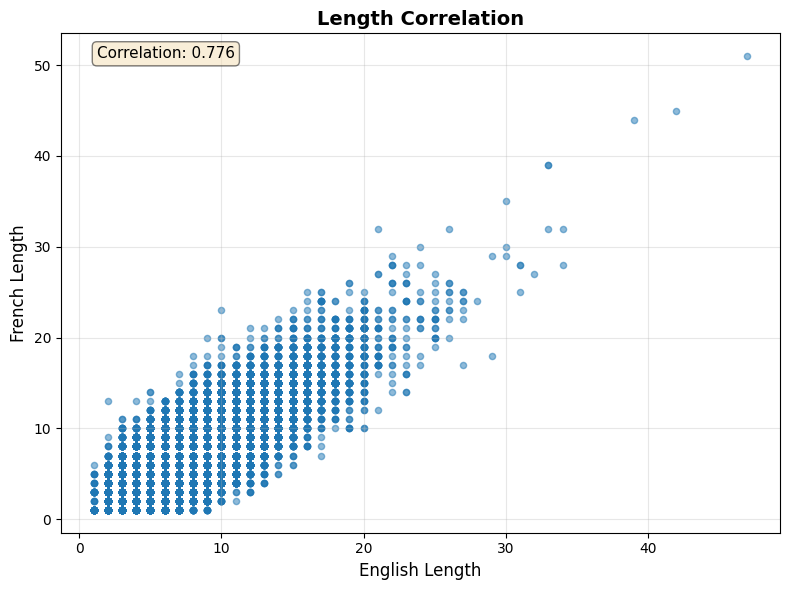

Saved: 04_top_english_words.png


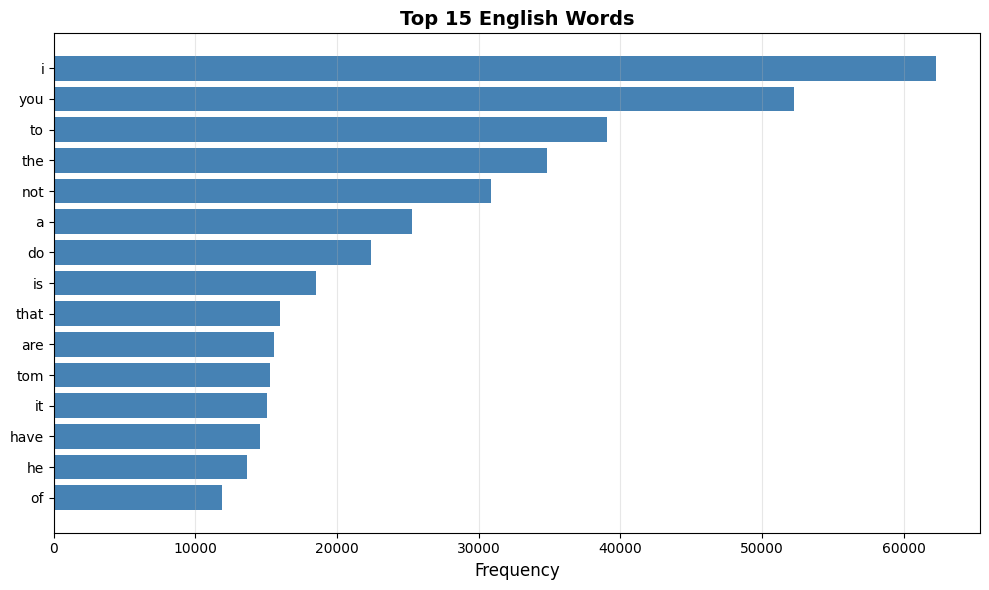

Saved: 05_top_french_words.png


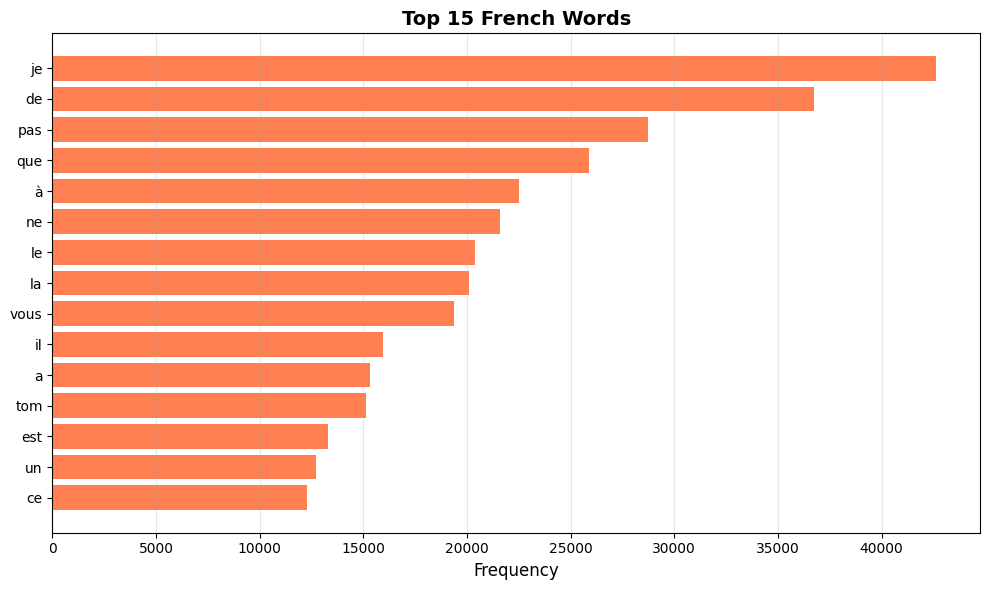

Saved: 06_vocabulary_growth.png


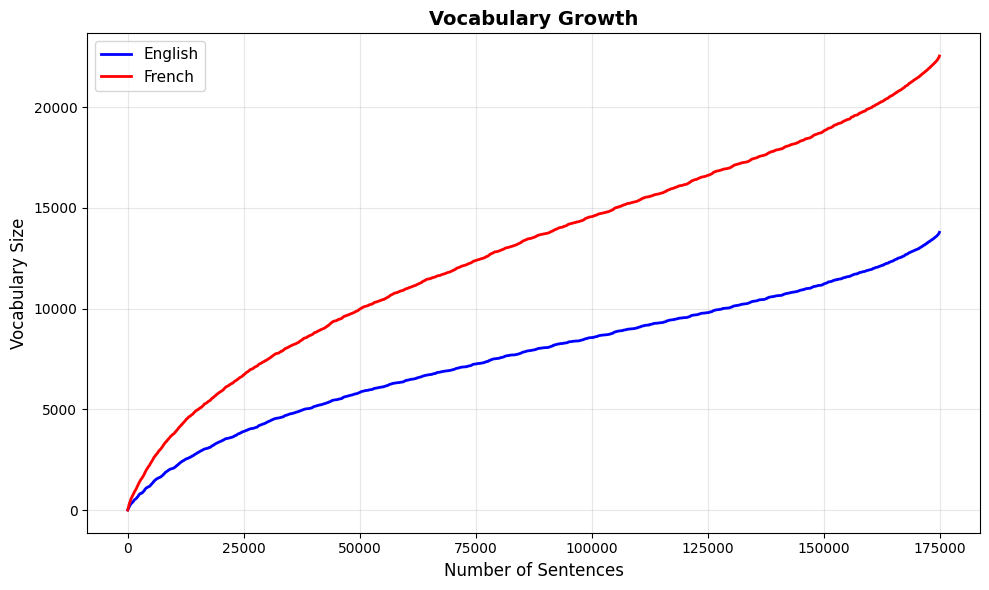

Saved: 07_length_ratio_distribution.png


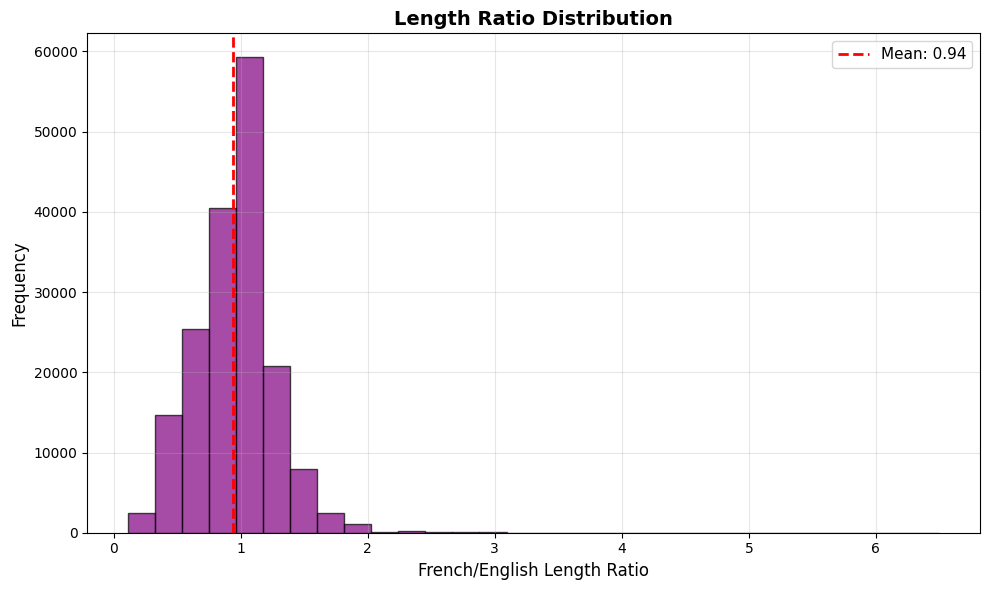

Saved: 08_statistics_summary.png


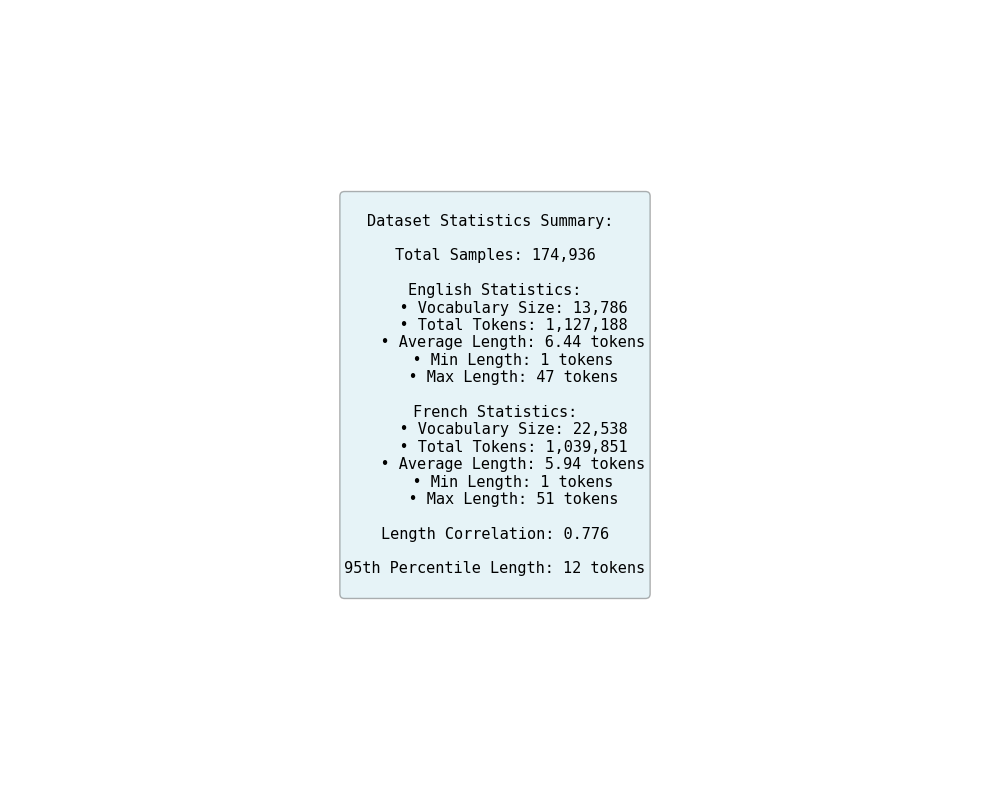

Saved: 09_english_wordcloud.png


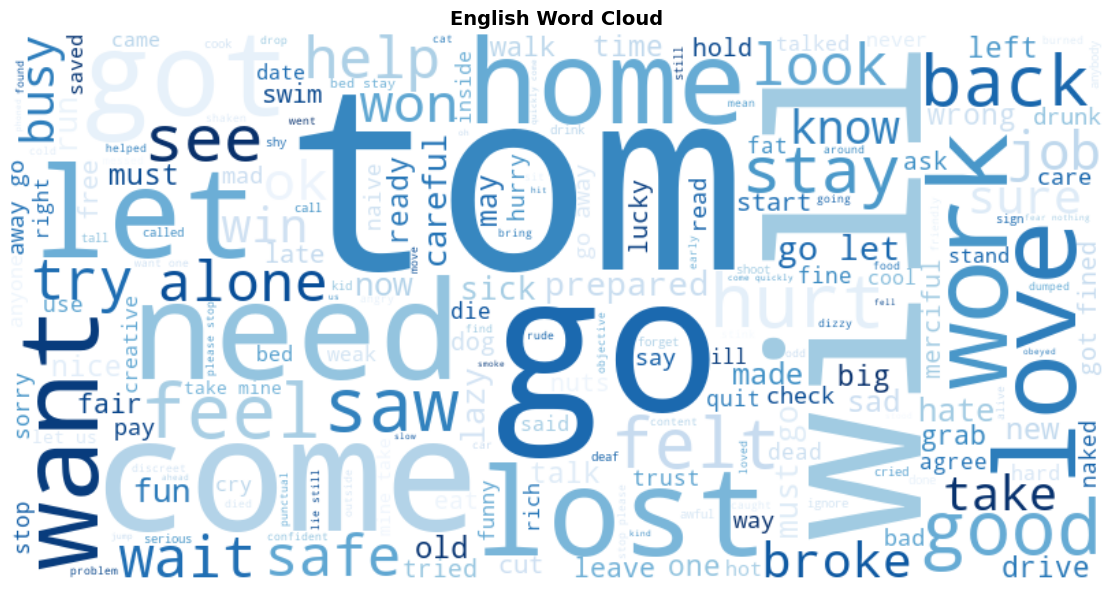

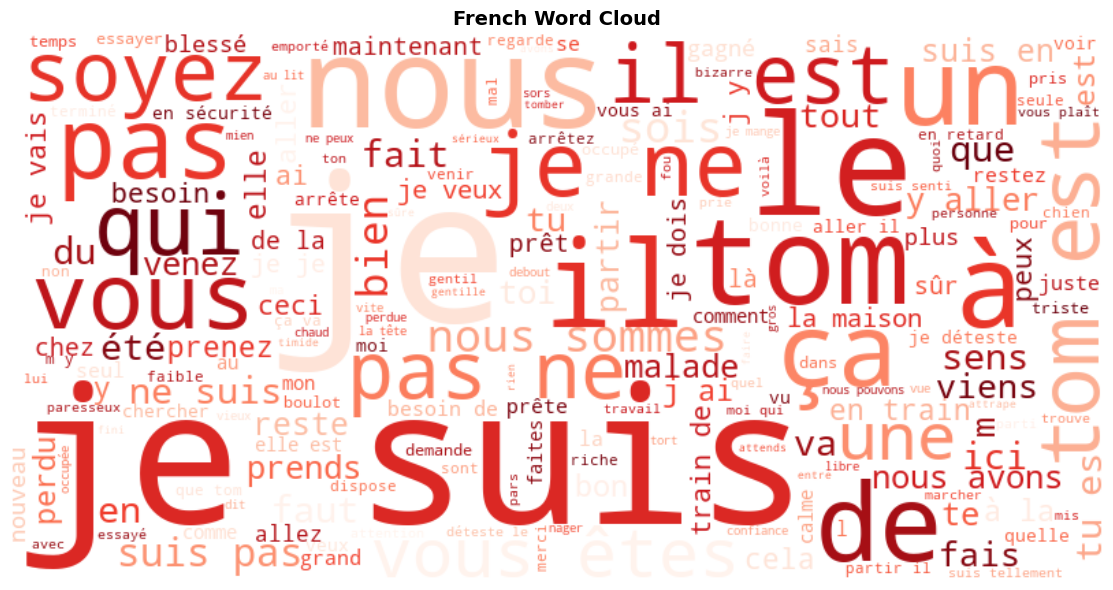

Saved: 10_french_wordcloud.png


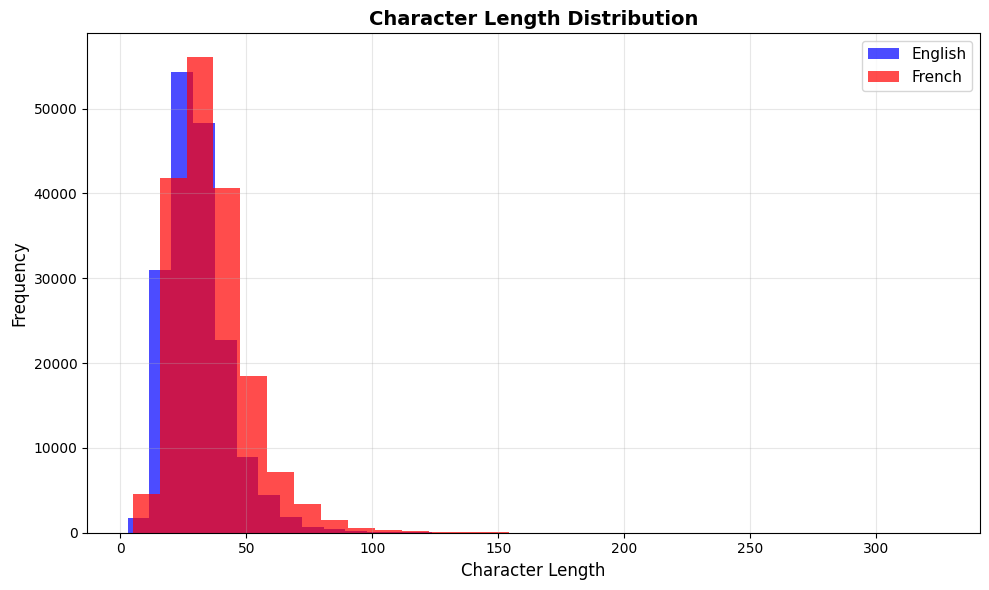

Saved: 11_character_length_distribution.png


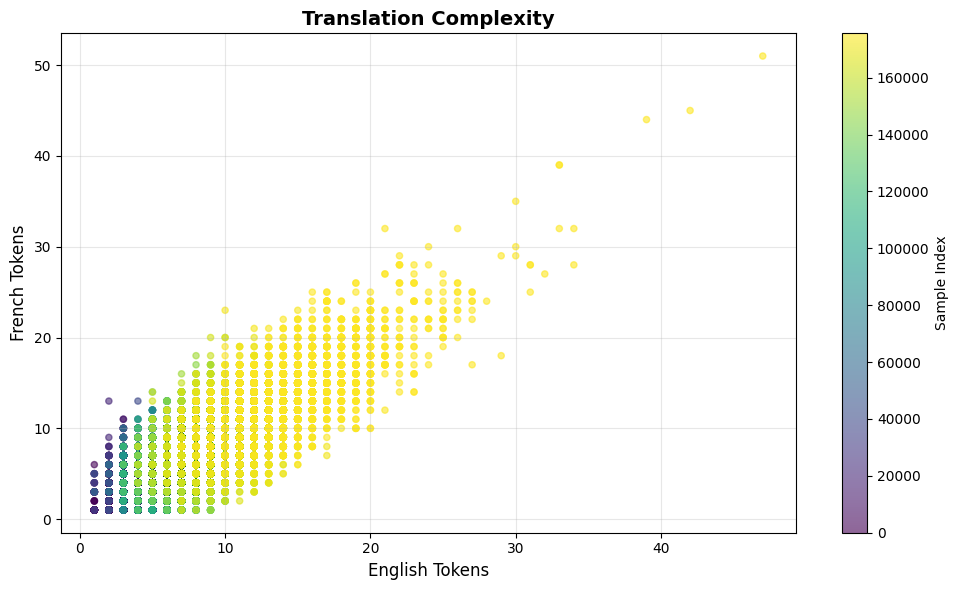

Saved: 12_translation_complexity.png
Using max_length: 50
Filtered dataset: 174935 samples (removed 1 long sequences)

Transformer-ready data shape: (174935, 4)

First few samples:
  source                  target  english_length  french_length
0     hi     <START> salut <END>               1              1
1    run     <START> cours <END>               1              1
2    run    <START> courez <END>               1              1
3    who       <START> qui <END>               1              1
4    wow  <START> ça alors <END>               1              2


In [10]:
preprocessor, data = main()